In [166]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
import re
from tensorflow.keras.layers import LeakyReLU

#ml non-deep learning tasks
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans

#visualisation
from wordcloud import WordCloud
import matplotlib.pyplot as plt

tf.test.is_gpu_available()

True

In [4]:
tf.__version__

'2.1.0'

## Load data

In [5]:
data = pd.read_csv('data/cards.csv')    
prices = pd.read_csv('data/prices.csv')

pd.options.display.max_columns = data.shape[1] #display option
# data.describe(include='all')

C:\Users\Przemyslaw\.conda\envs\mtg\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (6,9,12,16,40) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
data.head()

,index,id,artist,asciiName,borderColor,colorIdentity,colorIndicator,colors,convertedManaCost,duelDeck,edhrecRank,faceConvertedManaCost,flavorName,flavorText,frameEffect,frameEffects,frameVersion,hand,hasFoil,hasNoDeckLimit,hasNonFoil,isAlternative,isArena,isBuyABox,isDateStamped,isFullArt,isMtgo,isOnlineOnly,isOversized,isPaper,isPromo,isReprint,isReserved,isStarter,isStorySpotlight,isTextless,isTimeshifted,layout,leadershipSkills,life,loyalty,manaCost,mcmId,mcmMetaId,mtgArenaId,mtgoFoilId,mtgoId,multiverseId,name,names,number,originalText,originalType,otherFaceIds,power,printings,purchaseUrls,rarity,scryfallId,scryfallIllustrationId,scryfallOracleId,setCode,side,subtypes,supertypes,tcgplayerProductId,text,toughness,type,types,uuid,variations,watermark
0,0,1,Rebecca Guay,NaN,black,G,NaN,G,4.0,NaN,1011.0,NaN,NaN,NaN,NaN,NaN,2003,NaN,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,normal,NaN,NaN,NaN,{2}{G}{G},16413.0,19.0,NaN,27283.0,27282.0,130483.0,Abundance,NaN,249,"If you would draw a card, you may instead choo...",Enchantment,NaN,NaN,"10E,C17,DDR,USG",{'cardmarket': 'https://mtgjson.com/links/2b93...,rare,46184f97-d5c9-4a98-9fd9-e19057ce9b7e,4be12219-df08-4a40-b32f-69737db62615,eccc9a54-2b56-4a02-9926-258d5b2e25fb,10E,NaN,NaN,NaN,15023.0,"If you would draw a card, you may instead choo...",NaN,Enchantment,Enchantment,1669af17-d287-5094-b005-4b143441442f,NaN,NaN
1,1,2,Stephen Daniele,NaN,black,U,NaN,U,3.0,NaN,10859.0,NaN,NaN,They brandish their latest theories as warrior...,NaN,NaN,2003,NaN,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,normal,NaN,NaN,NaN,{1}{U}{U},16227.0,26.0,NaN,27275.0,27274.0,132072.0,Academy Researchers,NaN,63,"When Academy Researchers comes into play, you ...",Creature - Human Wizard,NaN,2,"10E,USG",{'cardmarket': 'https://mtgjson.com/links/27c7...,uncommon,b62ca800-ec24-476e-b56f-834eef9622a9,cf5efc65-9aa2-466b-bd2b-448ad69ab474,df2d2c52-475b-4057-9cf8-7886700f0fae,10E,NaN,"Human,Wizard",NaN,15024.0,When Academy Researchers enters the battlefiel...,2,Creature — Human Wizard,Creature,047d5499-a21c-5f5c-9679-1599fcaf9815,NaN,NaN
2,2,3,John Avon,NaN,black,"U,W",NaN,NaN,0.0,NaN,570.0,NaN,NaN,NaN,NaN,NaN,2003,NaN,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,normal,NaN,NaN,NaN,NaN,16511.0,42.0,NaN,27385.0,27384.0,129458.0,Adarkar Wastes,NaN,347,{T}: Add {1} to your mana pool.\n{T}: Add {W} ...,Land,NaN,NaN,"10E,5ED,6ED,7ED,9ED,ICE,PTC,WC00",{'cardmarket': 'https://mtgjson.com/links/7866...,rare,f31cf014-7ac9-428b-9ce9-8ba5ebfdd252,1b3845b2-2bac-4cfe-a0c5-6e9f4bd1edb8,d5ad26cc-2bdb-46b7-b8bf-dd099d5fa09b,10E,NaN,NaN,NaN,15025.0,{T}: Add {C}.\n{T}: Add {W} or {U}. Adarkar Wa...,NaN,Land,Land,ee19938c-4007-58f1-8904-fae28007b422,NaN,NaN
3,3,4,Roger Raupp,NaN,black,B,NaN,B,3.0,NaN,16135.0,NaN,NaN,"One rarely notices a heartbeat, save when it i...",NaN,NaN,2003,NaN,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,normal,NaN,NaN,NaN,{2}{B},16289.0,66.0,NaN,27483.0,27482.0,135206.0,Afflict,NaN,125,Target creature gets -1/-1 until end of turn.\...,Instant,NaN,NaN,"10E,ODY",{'cardmarket': 'https://mtgjson.com/links/02e8...,common,20f18447-2853-469b-b3b3-20d6bcafa6e7,83259a38-bbad-4dd1-bcd5-d1b1d96b0380,471f6ad3-cf01-42dd-a519-ea8e13039fea,10E,NaN,NaN,NaN,15026.0,Target creature gets -1/-1 until end of turn.\...,NaN,Instant,Instant,8774e18f-3752-5c06-af94-5da3960da9ed,NaN,NaN
4,4,5,Christopher Moeller,NaN,black,G,NaN,G,2.0,NaN,9933.0,NaN,NaN,"The power of the wild, concentrated in a singl...",NaN,NaN,2003,NaN,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,normal,NaN,NaN,NaN,{1}{G},16414.0,76.0,NaN,27361.0,27360.0,130525.0,Aggressive Urge,NaN,250,Target creature gets +1/+1 until end of turn.\...,Instant,NaN,NaN,"10E,INV,MB1,RIX",{'cardmarket': 'https://mtgjson.com/links/2ec1...,common,bf92ae01-9d1e-4b41-b068-096648daadf6,f4a2d3c4-15b8-4808-a5c5-56aaefc0dfcc,43f5a93b-0f8d-48d2-ab9d-275d44cf88b5,10E,NaN,NaN,NaN,15027.0,Target creature gets +1/+1 until end of turn.\...,NaN,Instant,Instant,4e875bca-0c52-5d60-889d-1db67e261737,NaN,NaN


In [7]:
# pd.get_dummies(data['frameEffects'])
# data['isStarter'].describe()

In [8]:
prices_no_duplicates = prices.drop_duplicates(subset=['uuid'])
# prices_no_duplicates.describe(include='all')

In [9]:
# prices.head()
# data.head()
data.columns

Index(['index', 'id', 'artist', 'asciiName', 'borderColor', 'colorIdentity',
       'colorIndicator', 'colors', 'convertedManaCost', 'duelDeck',
       'edhrecRank', 'faceConvertedManaCost', 'flavorName', 'flavorText',
       'frameEffect', 'frameEffects', 'frameVersion', 'hand', 'hasFoil',
       'hasNoDeckLimit', 'hasNonFoil', 'isAlternative', 'isArena', 'isBuyABox',
       'isDateStamped', 'isFullArt', 'isMtgo', 'isOnlineOnly', 'isOversized',
       'isPaper', 'isPromo', 'isReprint', 'isReserved', 'isStarter',
       'isStorySpotlight', 'isTextless', 'isTimeshifted', 'layout',
       'leadershipSkills', 'life', 'loyalty', 'manaCost', 'mcmId', 'mcmMetaId',
       'mtgArenaId', 'mtgoFoilId', 'mtgoId', 'multiverseId', 'name', 'names',
       'number', 'originalText', 'originalType', 'otherFaceIds', 'power',
       'printings', 'purchaseUrls', 'rarity', 'scryfallId',
       'scryfallIllustrationId', 'scryfallOracleId', 'setCode', 'side',
       'subtypes', 'supertypes', 'tcgplayerProduc

In [10]:
data_merged = pd.merge(data, prices_no_duplicates, on='uuid', how='inner')

In [11]:
data_merged.drop_duplicates(subset='name', keep="last", inplace=True)

### Include selected features

In [12]:
# len(data_merged)
data_merged = data_merged[['name', 'text', 'price', 'convertedManaCost', 'rarity', 'power', 'life','colors', 'manaCost',
                           'types', 'subtypes', 'loyalty', 'setCode', 'isReprint', 'isStarter', 'frameEffects']]
# print(data_merged.dtypes)

In [13]:
data_merged[data_merged.price > 100][['name', 'text', 'price', 'convertedManaCost']]

,name,text,price,convertedManaCost
5003,Ali from Cairo,Damage that would reduce your life total to le...,304.95,4.0
5006,Bazaar of Baghdad,"{T}: Draw two cards, then discard three cards.",1499.99,0.0
5012,City in a Bottle,Whenever one or more other nontoken permanents...,399.95,2.0
5021,Diamond Valley,"{T}, Sacrifice a creature: You gain life equal...",250.99,0.0
5022,Drop of Honey,"At the beginning of your upkeep, destroy the c...",419.96,1.0
...,...,...,...,...
34102,Ravages of War,Destroy all lands.,179.92,4.0
34182,Zodiac Dragon,When Zodiac Dragon is put into your graveyard ...,243.20,9.0
35944,Grim Tutor,Search your library for a card and put that ca...,231.87,3.0
39121,"Ugin, the Spirit Dragon","[+2]: Ugin, the Spirit Dragon deals 3 damage t...",138.21,8.0


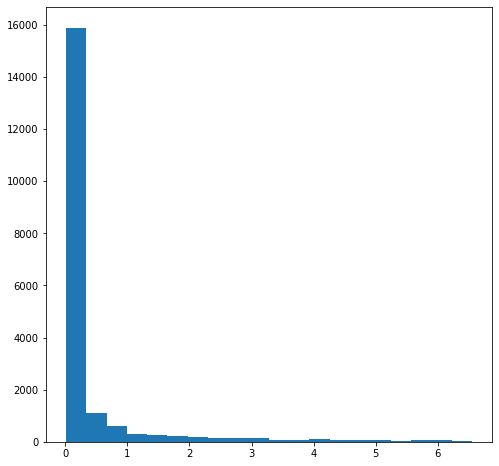

In [192]:
fig = plt.figure(1, figsize=(8, 8))
plt.hist(data_merged['price'].to_numpy(), bins=20)
plt.show()

In [194]:
data_merged['price'].quantile(0.95)

2.4214999999999782

In [195]:
data_merged['price'].describe(percentiles=[0.5, 0.7, 0.8, 0.9, 0.95])

count    19618.000000
mean         0.386039
std          0.970452
min          0.010000
50%          0.040000
70%          0.120000
80%          0.290000
90%          1.040000
95%          2.421500
max          6.550000
Name: price, dtype: float64

In [196]:
data_merged = data_merged[data_merged.price < data_merged['price'].quantile(0.95)]

In [197]:
data_merged['price'].describe()

count    18637.000000
mean         0.190861
std          0.395219
min          0.010000
25%          0.030000
50%          0.040000
75%          0.130000
max          2.420000
Name: price, dtype: float64

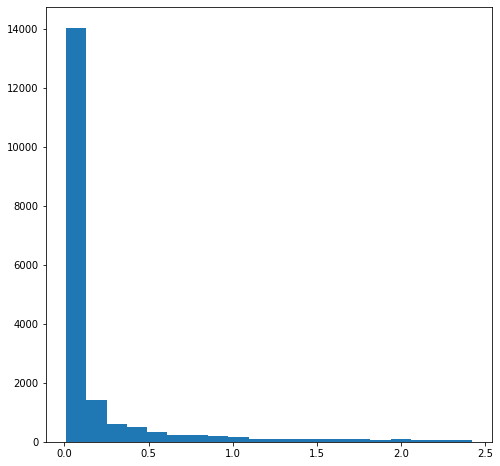

In [198]:
fig = plt.figure(1, figsize=(8, 8))
plt.hist(data_merged['price'].to_numpy(), bins=20)
plt.show()

## Text preprocessing

### visualise words

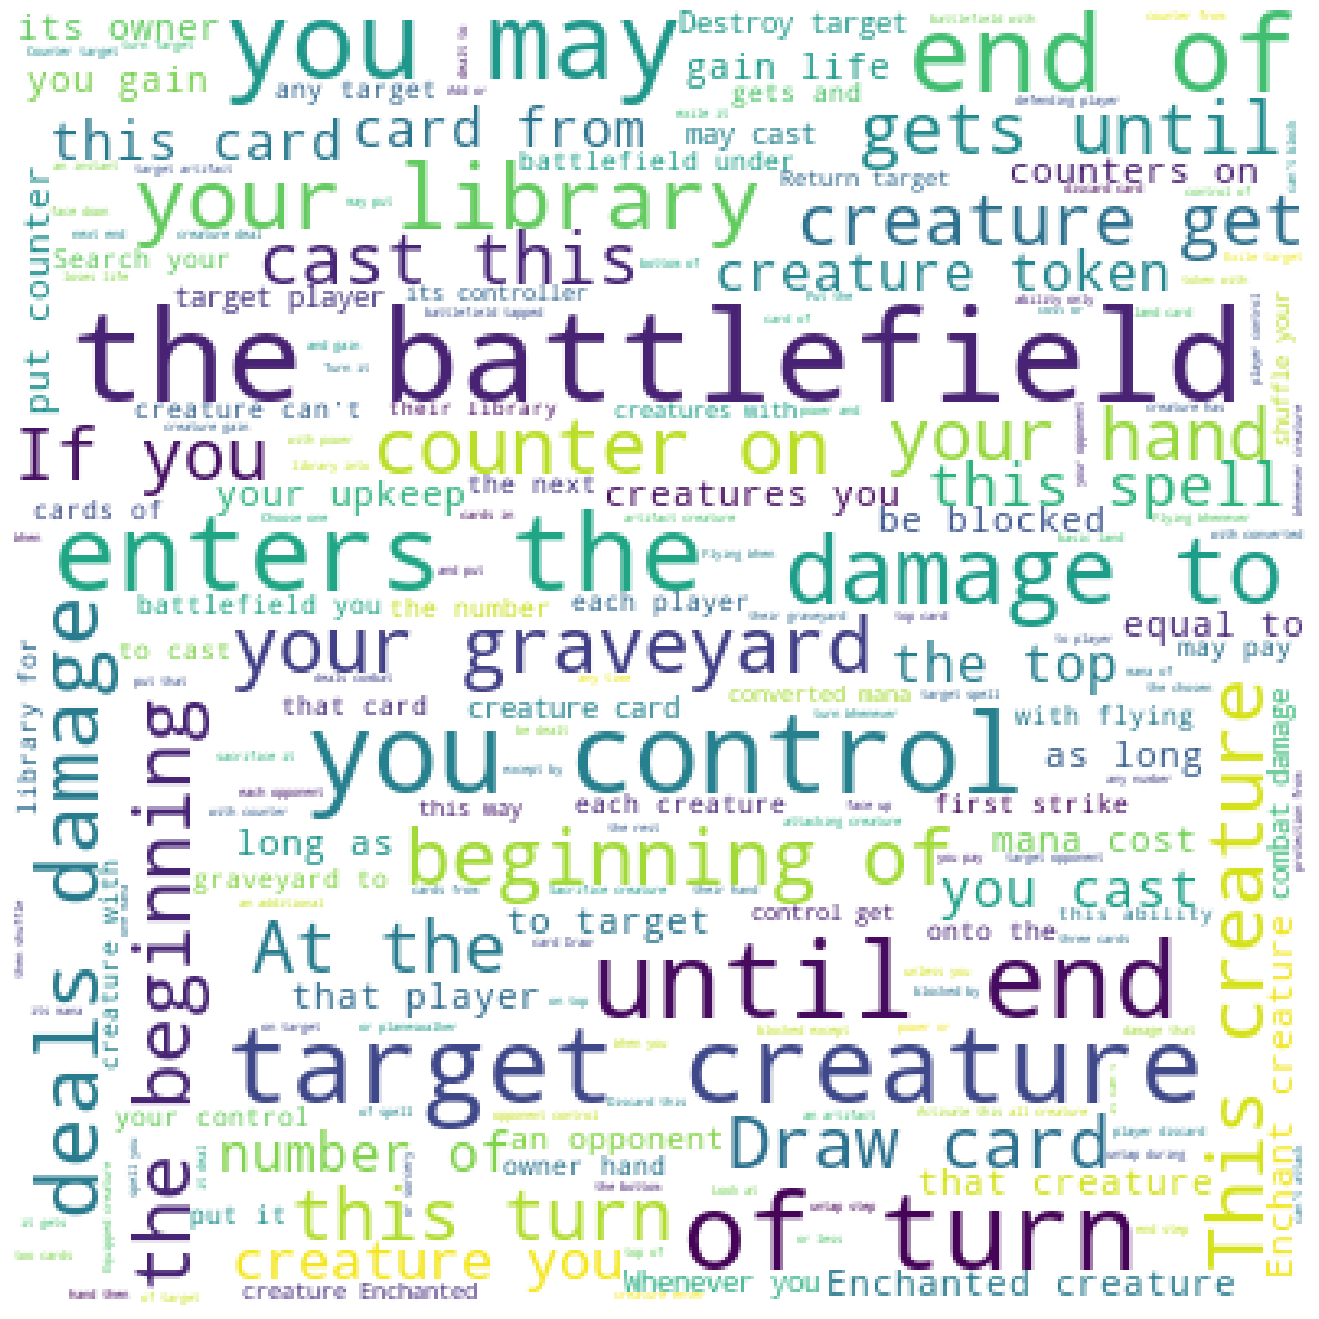

In [170]:
wc = WordCloud(background_color="white", max_words=200, width=400, height=400, random_state=1).generate(' '.join(data_merged['text']))
fig = plt.figure(1, figsize=(24, 24))
plt.axis('off')
plt.imshow(wc)
plt.show()

### Zamiania typu na string dla tokenizera

In [18]:
data_merged['text'] = data_merged['text'].astype(str)

### Tokenizacja

In [19]:
# vocab_size = 1000 #cannot be too long for lstm layer
vocab_size = 4096
max_length = 287 #95% cards will fit this text length
# max_length = 196 #80%

# max_length = data_merged.text.map(lambda x: len(x)).max()
# max_length = int((max_length * 3) / 4)

# max_length = 100
trunc_type='post'
# padding_type='post'
padding_type = 'pre'

In [20]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(data_merged['text'])
sequences = tokenizer.texts_to_sequences(data_merged['text'])

In [21]:
tokenizer.word_index

{'<OOV>': 1,
 'the': 2,
 'creature': 3,
 'you': 4,
 'a': 5,
 'of': 6,
 '1': 7,
 'your': 8,
 'target': 9,
 'to': 10,
 'this': 11,
 'it': 12,
 'card': 13,
 'turn': 14,
 '2': 15,
 'control': 16,
 'battlefield': 17,
 'or': 18,
 'and': 19,
 'that': 20,
 'if': 21,
 'damage': 22,
 'end': 23,
 'may': 24,
 'on': 25,
 'until': 26,
 'put': 27,
 'each': 28,
 'with': 29,
 'player': 30,
 'enters': 31,
 'as': 32,
 'when': 33,
 'whenever': 34,
 'from': 35,
 'creatures': 36,
 'cast': 37,
 't': 38,
 'for': 39,
 'library': 40,
 'its': 41,
 'flying': 42,
 'spell': 43,
 'an': 44,
 'cards': 45,
 'deals': 46,
 'hand': 47,
 'counter': 48,
 'gets': 49,
 '3': 50,
 'graveyard': 51,
 'at': 52,
 'any': 53,
 'life': 54,
 'sacrifice': 55,
 "can't": 56,
 'cost': 57,
 'be': 58,
 'x': 59,
 'is': 60,
 'draw': 61,
 'beginning': 62,
 'mana': 63,
 'then': 64,
 'in': 65,
 'exile': 66,
 'two': 67,
 'b': 68,
 'all': 69,
 'into': 70,
 'return': 71,
 'r': 72,
 'their': 73,
 'opponent': 74,
 'gain': 75,
 'land': 76,
 'upkeep': 7

### Padding

In [22]:
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
# padded

## Nontext features

In [23]:
max_nontext_length = 0

### Attach converted mana cost

In [24]:
# # data_merged['convertedManaCost'].to_numpy().reshape(-1, 1)
# padded = np.append(padded, data_merged['convertedManaCost'].to_numpy().reshape(-1, 1), axis=1)
# max_nontext_length += 1

### get rarity dummies

In [25]:
padded = np.append(padded, pd.get_dummies(data_merged['rarity'], drop_first=True).to_numpy(), axis=1)
max_nontext_length += 3

### Power

In [26]:
data_merged['power'] = pd.to_numeric(data_merged['power'], errors='coerce')
data_merged['power'].fillna(data_merged['power'].mean(), inplace=True)
# data_merged['power'].fillna(0, inplace=True)
padded = np.append(padded, data_merged['power'].to_numpy().reshape(-1, 1), axis=1)
max_nontext_length += 1
# data_merged['power']

### Life

In [27]:
data_merged['life'].fillna(data_merged['life'].mean(), inplace=True)
# data_merged['life'].fillna(0, inplace=True)
padded = np.append(padded, data_merged['life'].to_numpy().reshape(-1, 1), axis=1)
max_nontext_length += 1
# data_merged['life']

### loyalty

In [28]:
data_merged['loyalty'] = pd.to_numeric(data_merged['loyalty'], errors='coerce')
data_merged['loyalty'].fillna(data_merged['loyalty'].mean(), inplace=True)
# data_merged['loyalty'].notnull()
# data_merged['loyalty'][data_merged['loyalty'].notnull()]
padded = np.append(padded, data_merged['loyalty'].to_numpy().reshape(-1, 1), axis=1)
max_nontext_length += 1

### Set code

In [29]:
setcode_dummies = pd.get_dummies(data_merged['setCode'], drop_first=True)
padded = np.append(padded, setcode_dummies.to_numpy(), axis=1)
max_nontext_length += setcode_dummies.shape[1]

### is reprint

In [30]:
padded = np.append(padded, data_merged['isReprint'].to_numpy().reshape(-1, 1), axis=1)
max_nontext_length += 1

### is starter

In [31]:
padded = np.append(padded, data_merged['isStarter'].to_numpy().reshape(-1, 1), axis=1)
max_nontext_length += 1

### frame effects

In [32]:
frameeffects_dummies = pd.get_dummies(data_merged['frameEffects'], drop_first=True)
padded = np.append(padded, frameeffects_dummies.to_numpy(), axis=1)
max_nontext_length += frameeffects_dummies.shape[1]

### Mana cost

In [33]:
data_merged['manaCost'] = data_merged['manaCost'].astype(str)
index = data_merged['manaCost'].apply(lambda x: [y for y in [m.start() for m in re.finditer('{+|}+', x)]])
# index

In [34]:
colors = ['R', 'G', 'W', 'B', 'U']
colors_combinations = ['R/W', 'R/G', 'B/R', 'U/R', 'G/W', 'W/B', 'W/U', 'B/G', 'G/U', 'U/B']
life_pay_combinations = ['R/P', 'W/P', 'G/P', 'B/P', 'U/P']

combined = colors + colors_combinations + life_pay_combinations

manacost = np.zeros((len(data_merged['manaCost']), 22)) #first 2 for X pay and colorless pay
k = 0

for i, row in data_merged['manaCost'].iteritems():
#     print(i)
    values = []
    for j in range(0, len(index[i]), 2):
        first = index[i][j]
        second = index[i][j + 1]
        values.append(row[first + 1:second])
    for val in values:
        if val.isnumeric():
            manacost[k, 20] = int(val)
        elif val == 'X':
            manacost[k, 21] += 1
        else:
            try:
                occ = combined.index(val)
                manacost[k, occ] += 1
            except ValueError:
                pass
    k+= 1

padded = np.append(padded, manacost, axis=1)
max_nontext_length += 22

### types

In [35]:
types_dummies = pd.get_dummies(data_merged['types'], drop_first=True)
types_len = len(types_dummies.iloc[0, :])

padded = np.append(padded, types_dummies.to_numpy(), axis=1)
max_nontext_length += types_len

### subtypes

In [36]:
for i, row in data_merged['subtypes'].iteritems():
    print(row)

nan
Drone
Construct
Spider
nan
nan
Human,Wizard
nan
nan
Golem
nan
nan
Zombie,Beast
nan
Bringer
Bringer
Bringer
Bringer
Bringer
nan
nan
nan
Golem
nan
Beast
Elemental
nan
Aura
nan
Zombie,Crocodile
nan
Drake
nan
Equipment
nan
nan
Beast
nan
nan
Insect
Human,Warrior
nan
nan
Goblin,Warrior
nan
Equipment
nan
nan
Equipment
nan
Equipment
nan
nan
nan
Hellion,Beast
Elf,Druid
Goblin,Artificer
Ogre
nan
Cat,Soldier
nan
Elephant,Cleric
Elephant,Soldier
Golem
nan
Vampire
Human,Rogue,Rigger
Golem
Myr
Equipment
Zombie
Equipment
Ouphe,Rogue
Elemental
nan
nan
nan
Wall
nan
nan
nan
nan
nan
Construct
nan
nan
Construct
Equipment
nan
Insect
Aura
nan
Egg
nan
Construct
Snake
nan
Troll,Shaman
Construct
Dinosaur,Beast
nan
Vedalken,Wizard
nan
Elf,Shaman
Elf,Warrior,Scout
Cat,Knight
Human,Wizard
Construct
Aura
Human,Pilot
Human,Artificer
Elf,Artificer,Druid
Dwarf,Artificer
Human,Artificer
Vedalken,Artificer
Cat
Dwarf,Scout
nan
Elf,Soldier
Ajani
Dwarf,Rogue
Construct
Juggernaut
Assembly-Worker
nan
Construct
nan
Vehic

nan
nan
Human,Soldier
Cloud
Elemental
Zombie,Ogre
Lhurgoyf,Imp
Construct
Key
Zombie,Giant
nan
Mammoth
Aura
nan
Bear,Snake,Mutant
Human,Citizen
Spirit
Cat,Scout
Weird
nan
Bat,Fungus,Horror
nan
nan
nan
Arcane
Eldrazi,Insect
Antelope
Brushwagg
Island,Fish
Aura
Cephalid,Wizard
Horse
nan
Human,Advisor
Turtle
nan
nan
Elf,Warrior
nan
Insect
nan
Fish
Dog,Soldier
nan
Bird,Warrior
Elemental
nan
nan
nan
Insect,Locus
nan
nan
Fire
Equipment,Vehicle
Construct
nan
Demon
Human,Soldier,Wizard
nan
nan
nan
nan
nan
Avatar
Elemental
nan
nan
nan
nan
Demon
Elemental
Dragon
nan
Rat,Rogue
Spirit
Homunculus
Specter
nan
Rhino,Soldier
nan
nan
nan
nan
Leviathan
nan
Vampire
Aura
nan
Human,Knight
Avatar
Human,Wizard
Demon
nan
Human,Advisor
nan
Elf,Shaman
Human,Rogue
nan
nan
Bird
Zombie,Cleric
Human,Cleric
Human,Cleric
nan
Human,Warrior
nan
nan
Elf,Soldier
Wolf
nan
Human,Advisor
Goblin,Rogue
Goblin
Vampire
nan
nan
nan
nan
Bird,Illusion
nan
Human,Rogue,Mutant
Human,Knight
Elf,Rogue
Ooze
nan
Human,Warrior
nan
Human,Kni

Vampire
nan
Demon
nan
Demon
nan
nan
nan
nan
Vampire,Shaman,Ally
nan
Aura
Aura
Aura
Aura
Human,Knight
Faerie,Warlock
Aura
Faerie
nan
Bird
Archon
Human,Knight
Human,Knight
Elf,Noble
nan
nan
nan
Human,Warlock
Giant
Human,Knight
Human,Noble
Human,Knight
Wolverine
Faerie
Ouphe
Wall
Human,Knight
nan
nan
Cat
nan
Aura
Human,Noble
Human,Warlock
Human,Druid
Troll
nan
Gnome
Construct
nan
Wall
Equipment
Human,Peasant
nan
nan
Skeleton,Knight
nan
nan
nan
Mountain
Human,Peasant
Human,Knight
Human,Knight
Human,Knight
Human,Knight
Merfolk,Wizard
Vehicle
nan
nan
Faerie
Faerie,Wizard
Treefolk,Druid
Faerie
Faerie
Faerie,Rogue
Troll,Noble
nan
nan
Human,Knight
nan
Wolf
Human,Knight
nan
Human,Berserker
Fox
nan
nan
nan
nan
Zombie,Knight
Aura
Human,Wizard
Human,Warrior
Giant,Knight
Human,Soldier
Griffin
Garruk
Human,Peasant
nan
Equipment
Bird
Forest
Food,Golem
nan
Troll
Food
Goblin,Shaman
nan
Archon
Golem
nan
Faerie
Faerie
Plains
nan
Construct
nan
Human,Knight
nan
nan
Human,Wizard
nan
Scarecrow,Knight
Cat
Aura

Spider
nan
nan
Insect
nan
Human,Wizard
Human,Wizard
Insect
Turtle
Human,Scout
Brushwagg
Leviathan
Elk,Beast
Bird
nan
nan
nan
nan
Gremlin
Leech
nan
nan
nan
Beast
Human,Soldier
nan
Nightmare
nan
nan
Human,Soldier
Nightmare
nan
Dinosaur
Aura
nan
Crab
Giant
Cat
Human,Rogue
nan
Human,Soldier
nan
Bat
Human,Cleric
Human,Wizard
Elemental,Bird
Insect
Human,Cleric
nan
nan
Beast
Phoenix
Mole
nan
Wolf,Bear
Human,Wizard
Fox
Cat,Ape
nan
nan
nan
Fox
Antelope,Lizard
Aura
nan
Human,Warrior
Cat,Beast
nan
nan
Cat
Beast
Human,Soldier
nan
Elemental,Jellyfish
Nightmare,Pangolin
Spider
nan
Nightmare
nan
nan
nan
nan
Nightmare,Squirrel
Elephant
Human,Warrior
Human,Druid
Nightmare
Cat
Dinosaur
nan
Nightmare
nan
Human,Wizard
Human,Cleric
nan
nan
Elemental,Serpent
nan
Lizard,Beast
Insect
Human,Assassin
Unicorn
Cat
nan
nan
Beast
Dinosaur
nan
Beast
nan
Egg
Aura
nan
nan
Cat,Nightmare
nan
Human,Soldier
nan
nan
Elemental,Beast
Cat
Human,Soldier
Elemental,Whale
Frog
Bird,Beast
Shark,Beast
Monkey
nan
Human,Warrior
Eleme

Human,Shaman
Drake
nan
Rhino,Soldier
nan
Zombie
Equipment
nan
nan
nan
Zombie
Wall
Zombie
nan
Cat,Cleric
nan
nan
nan
Bird,Wizard
Bird,Soldier
Bird
nan
Insect
nan
nan
Human,Soldier
nan
Chandra
Golem
nan
nan
Human,Wizard
nan
Lizard
Human,Soldier
nan
Human,Wizard
nan
nan
Wurm
Vampire,Rogue
Skeleton
Wurm
Elf,Druid
nan
nan
Boar
nan
Garruk
nan
nan
Goblin
Cat
Human,Soldier
Human,Rogue
Serpent
Cat,Cleric
nan
nan
Human,Knight
Human,Knight
Shade
Merfolk
Viashino,Shaman
Demon
Human,Soldier
nan
Shapeshifter
Beast
Elephant
nan
nan
Ogre,Warrior
nan
Rhino,Monk
Equipment
Equipment
Equipment
Equipment
Equipment
nan
nan
nan
Spider
nan
Human,Cleric
Specter
Cat
Dragon
nan
Sphinx
Beast
nan
Dragon
nan
Zombie
Elemental
Aura
Bird
Human,Cleric
Hound
nan
nan
Elf,Shaman
Zombie,Giant
Human,Warrior
Elf,Shaman
Cat,Soldier
nan
Angel
Crab
Aura
Aura
Human,Cleric
nan
Sliver
Aura
Vampire
Sliver
Human,Wizard
nan
Wolf
Boar
nan
nan
Minotaur,Warrior
Human,Rogue
Cyclops
Aura
nan
nan
Human,Knight
Spider
Cockatrice
nan
nan
Drag

Wall
nan
Human,Wizard
Specter
Minotaur,Berserker
Serpent
Dragon
Aura
Drake
Imp
nan
Human,Knight
nan
nan
Griffin
Aura
nan
nan
nan
nan
nan
Faerie
Cat
nan
nan
Dryad
nan
Griffin
Nightstalker,Cat
Djinn
nan
Viashino,Warrior
Human,Cleric
Human,Druid
nan
nan
nan
Wall
Wall
Aura
Wurm
Elemental
Aura
Elephant
Bird
nan
nan
Unicorn
Human,Knight
Viashino,Shaman
Zombie
Griffin
Crocodile
nan
Hydra
Spider,Mutant
nan
Angel
Shapeshifter
Ogre,Warrior
nan
nan
Equipment
Equipment
Horror
Elemental,Mutant
Imp
nan
Arcane
Human,Knight
Bat
Human,Knight
nan
Spirit
Shapeshifter
Golem
Goblin,Warrior
Minotaur,Warrior
Elemental,Incarnation
Insect
Goblin,Soldier
Beast,Mutant
Spirit
Elemental
nan
Elemental,Shaman
Elemental,Warrior
nan
Spirit
Yeti
Kavu
nan
Snake
Human,Warrior
Shapeshifter
Spirit
Equipment
nan
Elemental
Spirit,Avatar
Human,Advisor,Mutant
nan
nan
nan
Aura
Spirit
Frog,Mutant
nan
Beast
nan
Skeleton,Warrior
nan
Spirit
nan
Drake
Spirit
Elemental
nan
nan
Human,Mutant
Phoenix
Cat,Knight
Elemental,Shaman
Elementa

Rabiah
Ravnica
Dominaria
Kaldheim
Kamigawa
nan
Innistrad
Rath
Kamigawa
Dominaria
Iquatana
Ulgrotha
Equilor
Phyrexia
Lorwyn
Segovia
Alara
Kyneth
nan
Vryn
Ergamon
Ir
Ravnica
Lorwyn
Belenon
Human,Monk
nan
Human,Soldier
Human,Soldier
nan
nan
Human,Soldier
nan
nan
nan
Human,Cleric
Angel
nan
Human,Artificer
Dragon
Bird,Cleric
nan
Elemental,Hound
Spirit
Human,Wizard
Vampire,Knight
Goblin,Warrior
Construct
nan
Fish,Lizard
Equipment
nan
Aura
Insect
nan
nan
Griffin
Human,Knight
nan
Aura
Human,Cleric
Aura
Human,Soldier
nan
nan
Elf,Shaman
Serpent
nan
Human,Wizard
nan
nan
Elf,Warrior
Bird
nan
Elf,Shaman
Cat,Monk
nan
Human,Warrior
Giant
Elf,Assassin
nan
Faerie,Rogue
Imp
Elemental,Hound
nan
Elemental
nan
nan
Zombie,Warrior
nan
nan
nan
Human,Artificer
Elf,Druid
Goblin,Warrior
Chimera
Aura
Construct
nan
Construct
nan
Human,Soldier
Equipment
Centaur,Shaman
Spider
nan
Aura
Aura
nan
nan
Human,Soldier
nan
nan
Human,Rogue
nan
Human,Knight
nan
Elf,Druid
nan
Elf,Shaman
Human,Warrior
Golem
nan
Vampire,Warrior


nan
Human,Wizard
Human,Rogue
nan
Illusion,Dragon
nan
Human,Knight
nan
nan
Serpent
nan
Drake
Djinn
nan
Horror
nan
nan
Dragon
Cat,Warrior
Elf
Insect
nan
Dragon
Imp
Snake
nan
Human,Monk
nan
nan
Spider
nan
Goblin
nan
Giant
Giant
nan
Cat
Elf,Archer
Human,Assassin
nan
Lizard,Warrior
Human,Mercenary,Knight
nan
Minotaur,Warrior
nan
Goat
nan
Frog
nan
Human,Barbarian
Plant,Elemental
Elemental
Cat
Minotaur,Berserker
Unicorn
nan
Treefolk
Human,Knight
nan
Snake,Assassin
Crocodile,Skeleton
Snake,Skeleton
nan
nan
Spirit
nan
Griffin
nan
Angel
Human,Soldier
nan
nan
nan
nan
Leviathan
Wurm
nan
Beast
nan
nan
nan
Wall
Wall
nan
Dryad
nan
Human,Monk
Sphinx
nan
Dryad
Horror
Elf,Warrior
Hellion
nan
nan
Elemental
nan
Elf,Warrior
Human,Warrior
Merfolk,Wizard
Human,Soldier
Human,Druid
Human,Knight
Demon
Human,Soldier
nan
Vedalken,Wizard
nan
Human,Artificer
Human,Cleric
Human,Soldier
Human,Berserker
Djinn
nan
nan
nan
Pegasus
Human,Wizard
Garruk
Nightstalker
Ajani
Avatar
Avatar
Djinn
Beast
Fungus,Beast
Equipment
Zo

nan
nan
nan
nan
Fox
Zombie,Giant
nan
Spirit,Knight
Human,Wizard
nan
Zombie
Human,Warrior,Werewolf
nan
Vampire,Wizard
Wolf
Spirit
nan
nan
Golem
Aura
Spirit
nan
nan
nan
nan
nan
Vampire,Berserker
Spirit
nan
Angel
nan
nan
Zombie,Horror
nan
nan
nan
nan
nan
Homunculus
nan
Human,Werewolf
Human,Rogue,Werewolf
nan
Zombie,Horror
Devil
nan
Spider
Angel
nan
Mole,Beast
nan
Aura
Human,Soldier
nan
Scarecrow
Equipment
Vampire
Human,Werewolf
nan
Human,Werewolf
Aura
Zombie,Hound
nan
Wolf
Devil
nan
Vampire
Vampire,Noble
Ooze
nan
Ox
Vampire
Human,Knight
Human,Scout
nan
Aura
nan
Jace
Boar,Horror
Human,Shaman,Werewolf
Human
Human,Shaman,Werewolf
Zombie,Horror
nan
Dryad,Horror
nan
nan
nan
Human,Wizard
Vampire,Knight
nan
nan
Human,Cleric
Demon
Fungus
nan
Spirit
Slug,Horror
Equipment
nan
nan
nan
Nahiri
Human,Cleric
Equipment
Drake
Spirit
nan
Human,Rogue
Human,Soldier
Vampire,Soldier
Vampire,Knight
nan
nan
Wolf,Spirit
Spirit
Human,Soldier
nan
nan
Human,Cleric
nan
nan
nan
Zombie
nan
Elemental,Hound
Wolf
Zombie,R

nan
Human,Knight
Human,Spellshaper
nan
Human,Rogue
nan
Construct
nan
nan
Sliver
Insect
Human,Spellshaper
Urza’s
Sliver
Sliver
Aura
Shapeshifter
Viashino,Scout
Homarid,Warrior
Spirit
Human,Wizard
nan
nan
Sliver
Human,Soldier
nan
nan
nan
nan
Dryad
nan
Dryad
Human,Rebel
nan
Ape
Aura
nan
Illusion
Elemental
Cyclops,Giant
Minion
nan
nan
Construct
Human,Wizard
Beeble
nan
nan
Human,Knight
Aura
Human,Knight
nan
Aura
Human,Wizard
Goat,Beast
nan
Aura
Rat
nan
Aura
Elf
Elf,Shaman
Crocodile
nan
nan
Juggernaut
Human,Cleric
nan
nan
Aura
Human,Cleric
nan
Bird
nan
nan
Elf
Goblin,Berserker
nan
Goblin
Goblin,Warrior
Goblin
Insect
Elf,Druid
Ogre
Bird,Beast
Aura
nan
Aura
Elf,Wizard
Human,Wizard
Bird
Human,Barbarian
Human,Rogue
Bird
nan
nan
nan
Insect
Aura
Insect
Aura
Human,Cleric
nan
Metathran,Soldier
Metathran,Soldier
Aura
nan
Human,Wizard
nan
Skeleton
Horror
Zombie,Hound
Spider
nan
nan
Aura
nan
nan
Human,Wizard
nan
Human,Monk,Cleric
nan
nan
nan
Elf,Druid
nan
nan
nan
nan
nan
nan
nan
nan
Angel
Aura
Horror
I

nan
nan
nan
nan
nan
nan
nan
nan
Jackal
nan
nan
Goblin
Human,Assassin
nan
nan
Soltari,Cleric
Human,Cleric
Spike
Aura
Thrull
nan
nan
Elemental
Plant,Wall
Plant,Wall
nan
nan
nan
nan
nan
Dragon
nan
nan
nan
nan
nan
nan
Golem
Elf,Druid
nan
nan
nan
nan
nan
Cat
Rat
nan
nan
nan
Human,Knight
nan
nan
Treefolk
nan
Aura
nan
nan
Elemental
Horror
nan
nan
Dragon
nan
nan
nan
Aura
Wolf
Human,Soldier
nan
nan
nan
Jellyfish
Elemental
Zombie
Human,Soldier
Human,Knight
Human,Cleric
Aura
Cyclops
nan
Elemental,Spirit
nan
Zombie
Aura
nan
nan
nan
nan
nan
nan
Giant
Wall
Bird
Djinn
Aura
nan
nan
nan
nan
nan
nan
nan
Bird
Dwarf,Berserker
Dwarf,Shaman
Aura
Illusion
Wurm
nan
nan
nan
nan
Aura
nan
nan
Djinn
nan
Elemental
Human,Soldier
Fungus,Elemental
nan
Horror
nan
nan
Goblin
Goblin,Rogue
nan
Wurm
nan
nan
nan
Human,Soldier
Horror
Minotaur,Shaman
nan
nan
nan
Construct
Aura
Hound
nan
Spirit
Elemental
Elf,Druid
Elf
nan
Aura
nan
Fish
Human,Warrior
Human,Soldier
Merfolk
nan
Spirit
Griffin
Horror
Ooze
Aura
nan
Atog
Human,Cler

### Preprocess prices

In [37]:
# prices.describe()
# prices.head()

In [38]:
prices_filtered = data_merged['price']

In [39]:
prices_np = prices_filtered.to_numpy()

### train, test split (90, 10)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(padded, prices_np, test_size=0.1, random_state=42)

### Standarize

In [41]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test = y_scaler.transform(y_test.reshape(-1, 1))

## Model

In [61]:
input_text_model = tf.keras.layers.Input(shape=(max_length,))
text_model = tf.keras.layers.Embedding(vocab_size, 256, input_length=max_length)(input_text_model)
text_model = tf.keras.layers.LSTM(256, return_sequences=True, activation = LeakyReLU(alpha=0.1))(text_model)
# text_model = tf.keras.layers.Dropout(0.5)(text_model) #
# text_model = tf.keras.layers.LSTM(128, return_sequences=True, activation = LeakyReLU(alpha=0.1))(text_model)
# text_model = tf.keras.layers.Dropout(0.4)(text_model)
text_model = tf.keras.layers.Flatten()(text_model)

input_non_text_model = tf.keras.layers.Input(shape=(max_nontext_length, ))
# non_text_model = tf.keras.layers.Dense(256, activation = LeakyReLU(alpha=0.1))(input_non_text_model)
non_text_model = tf.keras.layers.Dense(128, activation = LeakyReLU(alpha=0.1))(input_non_text_model)

concatenate_model = tf.keras.layers.Concatenate()([text_model, non_text_model])
# concatenate_model = tf.keras.layers.Dense(512, activation = LeakyReLU(alpha=0.1))(concatenate_model)
# concatenate_model = tf.keras.layers.Dropout(0.4)(concatenate_model)
concatenate_model = tf.keras.layers.Dense(512, activation = LeakyReLU(alpha=0.1))(concatenate_model)
# concatenate_model = tf.keras.layers.Dropout(0.3)(concatenate_model) #
# concatenate_model = tf.keras.layers.Dense(256, activation = LeakyReLU(alpha=0.1))(concatenate_model)
concatenate_model = tf.keras.layers.Dense(1)(concatenate_model)

model = Model([input_text_model, input_non_text_model], concatenate_model)

# input_text_model = tf.keras.layers.Input(shape=(max_length,))
# text_model = tf.keras.layers.Embedding(vocab_size, 128, input_length=max_length)(input_text_model)
# text_model = tf.keras.layers.LSTM(128, return_sequences=True, activation='relu')(text_model)
# text_model = tf.keras.layers.Dropout(0.3)(text_model)
# # text_model = tf.keras.layers.LSTM(128, return_sequences=True, activation = LeakyReLU(alpha=0.1))(text_model)
# # text_model = tf.keras.layers.Dropout(0.4)(text_model)
# text_model = tf.keras.layers.Flatten()(text_model)

# input_non_text_model = tf.keras.layers.Input(shape=(max_nontext_length, ))
# non_text_model = tf.keras.layers.Dense(256, activation='relu')(input_non_text_model)
# non_text_model = tf.keras.layers.Dense(128, activation='relu')(input_non_text_model)

# concatenate_model = tf.keras.layers.Concatenate()([text_model, non_text_model])
# concatenate_model = tf.keras.layers.Dense(512, activation='relu')(concatenate_model)
# # concatenate_model = tf.keras.layers.Dropout(0.4)(concatenate_model)
# concatenate_model = tf.keras.layers.Dense(256, activation='relu')(concatenate_model)
# # concatenate_model = tf.keras.layers.Dropout(0.3)(concatenate_model)
# # concatenate_model = tf.keras.layers.Dense(256, activation = LeakyReLU(alpha=0.1))(concatenate_model)
# concatenate_model = tf.keras.layers.Dense(1)(concatenate_model)

# model = Model([input_text_model, input_non_text_model], concatenate_model)

### Tensorboard

In [62]:
log_dir = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)

In [63]:
# optimizer = tf.keras.optimizers.Adam(0.00001)
optimizer = tf.keras.optimizers.Adam(0.0001)
rmse = tf.keras.metrics.RootMeanSquaredError()
# model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse', rmse])
model.compile(loss='mae', optimizer=optimizer, metrics=['mae', 'mse', rmse])

In [64]:
X_train[0].shape,max_length, vocab_size

((663,), 287, 4096)

### separate text and nontext data

In [68]:
X_train_text, X_train_nontext = X_train[:, 0:-max_nontext_length], X_train[:, -max_nontext_length:]
X_test_text, X_test_nontext = X_test[:, 0:-max_nontext_length], X_test[:, -max_nontext_length:]

### Train

In [66]:
epochs = 5
batch_size = 128
model.fit([X_train_text, X_train_nontext], y_train, epochs=epochs, callbacks=[tensorboard_callback], batch_size=batch_size, validation_split=0.2, shuffle=False)

Train on 14124 samples, validate on 3532 samples
Epoch 1/5
14124/14124 [==============================] - 66s 5ms/sample - loss: 0.3629 - mae: 0.3629 - mse: 0.9665 - root_mean_squared_error: 0.9831 - val_loss: 0.3327 - val_mae: 0.3327 - val_mse: 0.9863 - val_root_mean_squared_error: 0.9932
Epoch 2/5
14124/14124 [==============================] - 59s 4ms/sample - loss: 0.3033 - mae: 0.3033 - mse: 0.8093 - root_mean_squared_error: 0.8996 - val_loss: 0.3133 - val_mae: 0.3133 - val_mse: 0.8686 - val_root_mean_squared_error: 0.9320
Epoch 3/5
14124/14124 [==============================] - 58s 4ms/sample - loss: 0.2841 - mae: 0.2841 - mse: 0.7135 - root_mean_squared_error: 0.8447 - val_loss: 0.3058 - val_mae: 0.3058 - val_mse: 0.7917 - val_root_mean_squared_error: 0.8898
Epoch 4/5
14124/14124 [==============================] - 55s 4ms/sample - loss: 0.2716 - mae: 0.2716 - mse: 0.6495 - root_mean_squared_error: 0.8059 - val_loss: 0.2916 - val_mae: 0.2916 - val_mse: 0.7281 - val_root_mean_squar

### read some value

In [78]:
reverse_word_index = dict([(value, key) for (key, value) in tokenizer.word_index.items()])
def decode_sentence(text):
    text = scaler.inverse_transform(text)
    text = text[0:-max_nontext_length]
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

def decode_price(val):
    return y_scaler.inverse_transform(val)

In [ ]:
for i in range(100):
    price = decode_price(y_train[i])
    if price > 1:
        print(i)
        print(decode_price(y_train[i]))

In [ ]:
print(decode_sentence(X_train[70]))

In [ ]:
data_merged[data_merged['name'].str.contains("Zur the Enchanter")]

In [ ]:
np.argwhere(np.isnan(padded))

### evaluate

In [69]:
predictions = y_scaler.inverse_transform(model.predict((X_test_text, X_test_nontext)))
actual = y_scaler.inverse_transform(y_test)
mean_absolute_error(actual, predictions)

0.25272372948561256

## some predictions

In [116]:
np.set_printoptions(suppress=True)
predictions[30:40], actual[30:40]

(array([[ 0.05851358],
        [ 0.04780212],
        [-0.05288113],
        [ 0.02703839],
        [ 0.00296405],
        [ 1.5852759 ],
        [ 0.04705014],
        [ 0.07551104],
        [ 0.02857342],
        [ 0.17529234]], dtype=float32),
 array([[0.04],
        [0.04],
        [0.02],
        [0.04],
        [0.01],
        [2.  ],
        [0.04],
        [0.02],
        [0.03],
        [0.12]]))

In [117]:
decode_sentence(X_test[35])

"? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? 1 chandra flame's fury deals 2 damage to any target −2 chandra flame's ? deals 4 damage to target creature and 2 damage to that creature's controller −8 chandra flame's fury deals 10 damage to target player and each creature that player controls"

In [104]:
# data[data['name'].str.contains("Gallia")]
prices

,index,id,date,price,type,uuid
0,0,1,2020-04-20,0.12,mtgo,1669af17-d287-5094-b005-4b143441442f
1,1,2,2020-04-20,0.73,mtgoFoil,1669af17-d287-5094-b005-4b143441442f
2,2,3,2020-04-19,1.33,paper,1669af17-d287-5094-b005-4b143441442f
3,3,4,2020-04-19,33.03,paperFoil,1669af17-d287-5094-b005-4b143441442f
4,4,5,2020-04-20,0.03,mtgo,047d5499-a21c-5f5c-9679-1599fcaf9815
...,...,...,...,...,...,...
113297,113297,113298,2020-04-19,0.13,paper,d6b928f3-9776-5614-b20a-be969011e780
113298,113298,113299,2020-04-20,0.04,mtgo,6fcfeb10-c14a-5e9a-a074-506474b8c5de
113299,113299,113300,2020-04-20,0.01,mtgoFoil,6fcfeb10-c14a-5e9a-a074-506474b8c5de
113300,113300,113301,2020-04-19,0.04,paper,6fcfeb10-c14a-5e9a-a074-506474b8c5de


## ML non deep learning model

In [44]:
ml_model = LinearRegression()
ml_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [51]:
ml_model.score(X_test, y_test)

-1.598253408052378e+24

In [58]:
# ml_model.predict(X_test)
ml_predictions = y_scaler.inverse_transform(ml_model.predict(X_test))
ml_actual = y_scaler.inverse_transform(y_test)

ml_predictions[10:20], ml_actual[10:20]

(array([[ 1.82784998],
        [ 0.04101413],
        [ 1.66610833],
        [ 0.15797068],
        [ 1.83956266],
        [ 0.53174005],
        [-0.13293256],
        [ 0.04402744],
        [ 0.29835261],
        [ 2.53525316]]),
 array([[0.31],
        [0.04],
        [0.33],
        [1.05],
        [0.84],
        [0.22],
        [0.03],
        [0.05],
        [0.08],
        [4.01]]))

In [60]:
mean_absolute_error(ml_actual, ml_predictions)

41536993848.58114

## Clustering

In [129]:
kmeans = KMeans(n_clusters=20, random_state=0).fit(X_train)

In [131]:
kmeans.labels_[0:100]

array([ 3,  3,  3, 10,  3,  9, 10,  9,  9,  3,  3,  3, 10,  9,  3,  1,  3,
        9,  9,  9,  3,  9,  3,  3,  9,  9,  9, 10,  3,  9,  9,  3,  3,  9,
        9,  9,  3, 12,  9,  9, 10,  3,  3,  9,  3,  9,  3,  9, 16,  9,  3,
        9, 10,  3,  3,  3,  9,  9,  3,  9,  3,  1,  2,  9,  4, 10,  3,  3,
        3,  3, 10,  9,  9,  9, 10,  9,  3, 10,  9,  3,  3,  9,  9,  9,  3,
        3,  3,  9,  9,  3,  3,  3,  4,  3,  3, 10,  9,  3,  9,  9])

In [141]:
predictions = kmeans.predict(X_test)
predictions = [(i, predictions[i]) for i in range(len(predictions))]
predictions = sorted(predictions, key=lambda x: x[1])
predictions

[(669, 0),
 (911, 0),
 (913, 0),
 (1003, 0),
 (1285, 0),
 (1595, 0),
 (1601, 0),
 (1614, 0),
 (264, 1),
 (361, 1),
 (706, 1),
 (771, 1),
 (792, 1),
 (1059, 1),
 (1342, 1),
 (1507, 1),
 (1900, 1),
 (482, 2),
 (568, 2),
 (734, 2),
 (1005, 2),
 (1044, 2),
 (1083, 2),
 (1089, 2),
 (1189, 2),
 (1260, 2),
 (1551, 2),
 (1658, 2),
 (1682, 2),
 (1759, 2),
 (1889, 2),
 (2, 3),
 (3, 3),
 (9, 3),
 (16, 3),
 (17, 3),
 (20, 3),
 (23, 3),
 (25, 3),
 (31, 3),
 (32, 3),
 (34, 3),
 (36, 3),
 (37, 3),
 (38, 3),
 (40, 3),
 (41, 3),
 (44, 3),
 (48, 3),
 (50, 3),
 (53, 3),
 (54, 3),
 (55, 3),
 (58, 3),
 (61, 3),
 (63, 3),
 (64, 3),
 (66, 3),
 (69, 3),
 (70, 3),
 (71, 3),
 (72, 3),
 (75, 3),
 (80, 3),
 (82, 3),
 (86, 3),
 (88, 3),
 (89, 3),
 (90, 3),
 (92, 3),
 (93, 3),
 (94, 3),
 (95, 3),
 (106, 3),
 (107, 3),
 (111, 3),
 (119, 3),
 (122, 3),
 (124, 3),
 (125, 3),
 (134, 3),
 (138, 3),
 (147, 3),
 (153, 3),
 (154, 3),
 (160, 3),
 (165, 3),
 (167, 3),
 (168, 3),
 (172, 3),
 (173, 3),
 (174, 3),
 (177, 3),
 (

In [156]:
decode_sentence(X_test[86])

'? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? counter target spell if its converted mana cost is less than or equal to the highest converted mana cost among permanents you control'